In [1]:
!pip install -q transformers
!pip install -q sentencepiece
!pip install -q jiwer
!pip install -q datasets
!pip install -q evaluate
!pip install -q -U accelerate
!pip install -q matplotlib
!pip install -q protobuf==3.20.1
!pip install -q tensorboard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.4.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.20.1 which is incompatible.
google-api-core 2.11.1 requires protobuf!=3.20.0,!=3.20.1,!=4.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/ocr_dataset-20240309T175315Z-001.zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/ocr_dataset/train_masks/4174.png  
  inflating: /content/ocr_dataset/train_masks/4202.png  
  inflating: /content/ocr_dataset/train_masks/4165.png  
  inflating: /content/ocr_dataset/train_masks/4176.png  
  inflating: /content/ocr_dataset/train_masks/4192.png  
  inflating: /content/ocr_dataset/train_masks/4170.png  
  inflating: /content/ocr_dataset/train_masks/4187.png  
  inflating: /content/ocr_dataset/train_masks/4162.png  
  inflating: /content/ocr_dataset/train_masks/4175.png  
  inflating: /content/ocr_dataset/train_masks/4196.png  
  inflating: /content/ocr_dataset/train_masks/4161.png  
  inflating: /content/ocr_dataset/train_masks/4182.png  
  inflating: /content/ocr_dataset/train_masks/4157.png  
  inflating: /content/ocr_dataset/train_masks/4159.png  
  inflating: /content/ocr_dataset/train_masks/4185.png  
  inflating: /content/ocr_dataset/train_masks/4172.png  
  inflating: /content/ocr_dataset/tra

In [4]:
import os
import os
import torch
import evaluate
import numpy as np
import pandas as pd
import glob as glob
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
from zipfile import ZipFile
from tqdm.notebook import tqdm
from dataclasses import dataclass
from torch.utils.data import Dataset
from urllib.request import urlretrieve
from transformers import (
    VisionEncoderDecoderModel,
    TrOCRProcessor,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    default_data_collator
)

In [5]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:    int = 8
    EPOCHS:        int = 10
    LEARNING_RATE: float = 1e-5

@dataclass(frozen=True)
class DatasetConfig:
    DATA_ROOT:     str = '/content/ocr_dataset'

@dataclass(frozen=True)
class ModelConfig:
    MODEL_NAME: str = 'microsoft/trocr-small-printed'

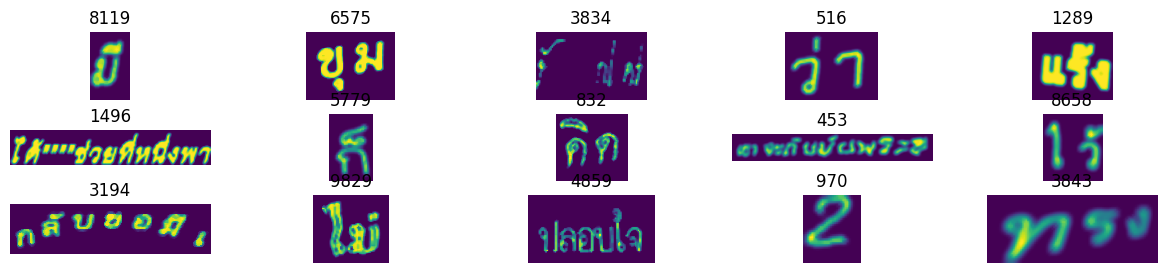

In [7]:
def visualize(dataset_path):
    plt.figure(figsize=(15, 3))
    for i in range(15):
        plt.subplot(3, 5, i+1)
        all_images = os.listdir(f"{dataset_path}/train_masks")
        image = plt.imread(f"{dataset_path}/train_masks/{all_images[i]}")
        plt.imshow(image)
        plt.axis('off')
        plt.title(all_images[i].split('.')[0])
    plt.show()

visualize(DatasetConfig.DATA_ROOT)

In [9]:
df = pd.read_fwf(os.path.join(DatasetConfig.DATA_ROOT, '/content/ocr_dataset/gt.txt'), header=None)
df[['file_name', 'text']] = df[0].str.split('\t', n=1, expand=True)
df['file_name'] = df['file_name'].str.replace('images/[0-6]/', '', regex=True)
df['file_name'] = df['file_name'].str.replace('jpg', 'png', regex=True)
df.drop(columns=[0], inplace=True)
df

,file_name,text
0,0.png,เท่า
1,3.png,ท
2,1.png,กาสี
3,6.png,หนึ่ง
4,5.png,จะ
...,...,...
65001,65000.png,เมื่อ
65002,65004.png,แก่
65003,65005.png,ที่ลามาเจ้าเที่ย
65004,65001.png,ได้รับ


In [10]:
from tqdm import tqdm

path = "/content/ocr_dataset/train_masks/"
file_name = []
text = []

for i in tqdm(range(len(df))):
    try:
        image = Image.open(path + df['file_name'][i])
        file_name.append(df['file_name'][i])
        text.append(df['text'][i])
    except:
        pass

df = pd.DataFrame({
    "file_name": 	file_name,
    "text": text
})
df

100%|██████████| 65006/65006 [00:03<00:00, 19972.44it/s]


,file_name,text
0,0.png,เท่า
1,3.png,ท
2,1.png,กาสี
3,6.png,หนึ่ง
4,5.png,จะ
...,...,...
9995,9998.png,หนึ่ง
9996,9997.png,ข้าง
9997,9999.png,ขณะนั้น
9998,9996.png,เชตวัน


In [72]:
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=.5, hue=.3),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
])

In [73]:
from torch.utils.data import Dataset
from PIL import Image
from sklearn.model_selection import train_test_split

class CustomOCRDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df.iloc[idx]['file_name']
        text = self.df.iloc[idx]['text']
        image = Image.open(os.path.join(self.root_dir, file_name)).convert('RGB')
        image = train_transforms(image)
        pixel_values = self.processor(image, return_tensors='pt').pixel_values
        labels = self.processor.tokenizer(
            text,
            padding='max_length',
            max_length=self.max_target_length
        ).input_ids
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = CustomOCRDataset(
    root_dir=os.path.join(DatasetConfig.DATA_ROOT, 'train_masks/'),
    df=train_df,
    processor=processor
)

valid_dataset = CustomOCRDataset(
    root_dir=os.path.join(DatasetConfig.DATA_ROOT, 'train_masks/'),
    df=test_df,
    processor=processor
)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [74]:
model = VisionEncoderDecoderModel.from_pretrained(ModelConfig.MODEL_NAME)
model.to(device)
print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(

In [75]:
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size
model.config.eos_token_id = processor.tokenizer.sep_token_id

model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

optimizer = optim.AdamW(
    model.parameters(), lr=TrainingConfig.LEARNING_RATE, weight_decay=0.0005
)

In [76]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy='epoch',
    per_device_train_batch_size=TrainingConfig.BATCH_SIZE,
    per_device_eval_batch_size=TrainingConfig.BATCH_SIZE,
    fp16=True,
    output_dir='seq2seq_model_printed/',
    logging_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=5,
    report_to='tensorboard',
    num_train_epochs=TrainingConfig.EPOCHS
)

trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=default_data_collator
)

/usr/local/lib/python3.10/dist-packages/transformers/models/trocr/processing_trocr.py:136: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [78]:
res = trainer.train()

Epoch,Training Loss,Validation Loss
1,2.049500,1.226167
2,1.070700,0.777431
3,0.746200,0.639089
4,0.555400,0.496270
5,0.417700,0.409668
6,0.323900,0.336320
7,0.242300,0.315518
8,0.183100,0.304421
9,0.134700,0.284230
10,0.096700,0.288836


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be 

In [79]:
!cp -r /content/seq2seq_model_printed/checkpoint-9000 /content/drive/MyDrive/checkpoint-9000

In [80]:
processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)
trained_model = VisionEncoderDecoderModel.from_pretrained('seq2seq_model_printed/checkpoint-9000').to(device)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [ ]:
def read_and_show(image_path, prefix_to_remove='images/[0-6]/'):
    image_path = image_path.replace(prefix_to_remove, '')
    image = Image.open(image_path).convert('RGB')
    return image

def ocr(image, processor, model):
    pixel_values = processor(image, return_tensors='pt').pixel_values.to(device)
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

def eval_new_data(
    data_path=os.path.join(DatasetConfig.DATA_ROOT, 'scut_test', '*'),
    num_samples=50
):
    image_paths = glob.glob(data_path)
    for i, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
        if i == num_samples:
            break
        image = read_and_show(image_path)
        text = ocr(image, processor, trained_model)
        plt.figure(figsize=(7, 4))
        plt.imshow(image)
        plt.title(text)
        plt.axis('off')
        plt.show()

eval_new_data(
    data_path=os.path.join(DatasetConfig.DATA_ROOT, '/content/ocr_dataset/train_masks', '*'),
    num_samples=100
)

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1339: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3617 (\N{THAI CHARACTER MO MA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
